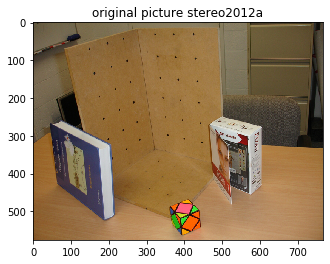

In [102]:
# -*- coding: utf-8 -*-
# CLAB3 
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
I = plt.imread('stereo2012a.jpg');
plt.title('original picture stereo2012a')
plt.imshow(I)

In [122]:
uv = np.load('uvPoint.npy')
XYZ = np.array(([0, 14, 21], 
                [0,7, 28],
               [14, 0, 14],
               [21, 0, 7],
               [7, 14, 0],
               [14, 21, 0]))
np.save("XYZ", XYZ)

In [137]:
#####################################################################

'''
%% TASK 1: CALIBRATE
%
% Function to perform camera calibration
%
% Usage:   calibrate(image, XYZ, uv)
%          return C
%   Where:   image - is the image of the calibration target.
%            XYZ - is a N x 3 array of  XYZ coordinates
%                  of the calibration target points. 
%            uv  - is a N x 2 array of the image coordinates
%                  of the calibration target points.
%            K   - is the 3 x 4 camera calibration matrix.
%  The variable N should be an integer greater than or equal to 6.
%
%  This function plots the uv coordinates onto the image of the calibration
%  target. 
%
%  It also projects the XYZ coordinates back into image coordinates using
%  the calibration matrix and plots these points too as 
%  a visual check on the accuracy of the calibration process.
%
%  Lines from the origin to the vanishing points in the X, Y and Z
%  directions are overlaid on the image. 
%
%  The mean squared error between the positions of the uv coordinates 
%  and the projected XYZ coordinates is also reported.
%
%  The function should also report the error in satisfying the 
%  camera calibration matrix constraints.
% 
% Tianjun Peng, 12/10/2020 
'''
def calibrate(im, XYZ, uv):
    # TBD
    C = None
    n = len(uv)
    b = uv.reshape((2*n, 1))
    X,Y,Z = XYZ[:, 0],XYZ[:, 1],XYZ[:, 2]
    list_A = []
    for i in range(n):
        list_A.append([X[i], Y[i], Z[i], 1, 0, 0, 0, 0, -X[i]*uv[i, 0], -Y[i]*uv[i, 0], -Z[i]*uv[i, 0]])
        list_A.append([0, 0, 0, 0, X[i], Y[i], Z[i], 1, -X[i]*uv[i, 1], -Y[i]*uv[i, 1], -Z[i]*uv[i, 1]])
    A = np.asarray(list_A)

    q = np.linalg.lstsq(A, b, rcond='warn')[0]
    q = np.vstack((q, [1]))
    
    C = q.reshape((3, 4))
    
    X = X.reshape((1, len(XYZ)))
    Y = Y.reshape((1, len(XYZ)))
    Z = Z.reshape((1, len(XYZ)))
    
    u = (q[0]*X + q[1]*Y + q[2]*Z + q[3]) / (q[8]*X + q[9]*Y + q[10]*Z + 1)
    v = (q[4]*X + q[5]*Y + q[6]*Z + q[7])/ (q[8]*X + q[9]*Y + q[10]*Z + 1)
    plt.scatter(uv[:, 0], uv[:, 1], color='r')
    plt.scatter(u, v, color='b')
    plt.title('choosen uv (red) and recovered uv(blue)')
    plt.imshow(im)
    
    return C


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[ 4.51903566e+00 -1.85426723e+00 -5.79524068e+00  3.26881053e+02]
 [ 5.83983814e-01 -7.18750997e+00  2.20688082e+00  3.31391363e+02]
 [-3.34394684e-03 -2.47305024e-03 -3.53024315e-03  1.00000000e+00]]


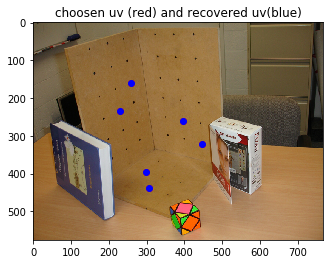

In [138]:
uv = np.load("uvPoint.npy")
XYZ = np.load("XYZPoint.npy")
C = calibrate(I, XYZ, uv)
print(C)

In [85]:
# %VGG_KR_FROM_P Extract K, R from camera matrix.
# %
# %    [K,R,t] = VGG_KR_FROM_P(P [,noscale]) finds K, R, t such that P = K*R*[eye(3) -t].
# %    It is det(R)==1.
# %    K is scaled so that K(3,3)==1 and K(1,1)>0. Optional parameter noscale prevents this.
# %
# %    Works also generally for any P of size N-by-(N+1).
# %    Works also for P of size N-by-N, then t is not computed.

# % original Author: Andrew Fitzgibbon <awf@robots.ox.ac.uk> and awf
# % Date: 15 May 98

# % Modified by Shu.
# % Date: 8 May 20
import numpy as np

def vgg_rq(S):
    S = S.T
    [Q,U] = np.linalg.qr(S[::-1,::-1], mode='complete')

    Q = Q.T
    Q = Q[::-1, ::-1]
    U = U.T
    U = U[::-1, ::-1]
    if np.linalg.det(Q)<0:
        U[:,0] = -U[:,0]
        Q[0,:] = -Q[0,:]
    return U,Q


def vgg_KR_from_P(P, noscale = True):
    N = P.shape[0]
    H = P[:,0:N]
    print(N,'|', H)
    [K,R] = vgg_rq(H)
    if noscale:
        K = K / K[N-1,N-1]
        if K[0,0] < 0:
            D = np.diag([-1, -1, np.ones([1,N-2])]);
            K = K @ D
            R = D @ R
        
            test = K*R; 
            assert (test/test[0,0] - H/H[0,0]).all() <= 1e-07
    
    t = np.linalg.inv(-P[:,0:N]) @ P[:,-1]
    return K, R, t

K, R, t = vgg_KR_from_P(C)
print('Intrinsic matrix',K)
print('Rotation matrix',R)
print('Transformation matrix',t)

3 | [[ 4.90003310e+00 -2.41419151e+00 -5.99888673e+00]
 [ 1.62657525e+00 -7.36561161e+00  2.67182582e+00]
 [-1.40374208e-03 -3.72109115e-03 -3.15989656e-03]]
Intrinsic matrix [[ 1.36889690e+03 -1.05012906e+02  8.16252239e+02]
 [ 0.00000000e+00  1.43660411e+03  6.46545010e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Rotation matrix [[ 0.89612056  0.03747937 -0.44222533]
 [ 0.34727235 -0.67966846  0.6461058 ]
 [-0.27635097 -0.73256132 -0.62208043]]
Transformation matrix [133.86964634 117.16527608 119.02252655]


In [128]:
s = K[0][1]

In [134]:
import math
math.degrees(math.atan(s))

-89.45440946183543

Task2

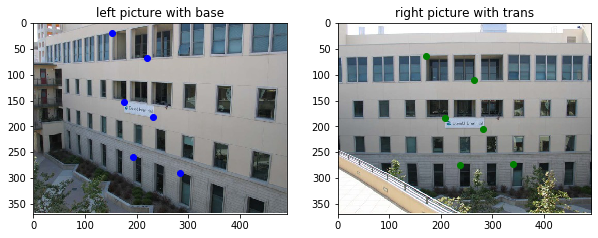

In [151]:
left = plt.imread('Left.jpg')
right = plt.imread('Right.jpg')
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('left picture with base')
uvbase = np.load('uvBase.npy')
plt.scatter(uvbase[:,0],uvbase[:,1],c='b')
plt.imshow(left)
plt.subplot(1,2,2)
plt.title('right picture with trans')
uv2Trans = np.load('uv2Trans.npy')
plt.scatter(uv2Trans[:,0],uv2Trans[:,1],c='g')
plt.imshow(right)

In [300]:

'''
%% TASK 2: 
% Computes the homography H applying the Direct Linear Transformation 
% The transformation is such that 
% p = np.matmul(H, p.T), i.e.,
% (uBase, vBase, 1).T = np.matmul(H, (u2Trans , v2Trans, 1).T)
% Note: we assume (a, b, c) => np.concatenate((a, b, c), axis), be careful when 
% deal the value of axis 
%
% INPUTS: 
% u2Trans, v2Trans - vectors with coordinates u and v of the transformed image point (p') 
% uBase, vBase - vectors with coordinates u and v of the original base image point p  
% 
% OUTPUT 
% H - a 3x3 Homography matrix  
% 
% your name, date 
'''


############################################################################
def rq(A):
    # RQ factorisation
    
    [q,r] = np.linalg.qr(A.T)   # numpy has QR decomposition, here we can do it 
                                # with Q: orthonormal and R: upper triangle. Apply QR
                                # for the A-transpose, then A = (qr).T = r.T@q.T = RQ
    R = r.T
    Q = q.T
    return R,Q

In [301]:
def homography(u2Trans, v2Trans, uBase, vBase):
    H = None
    n = len(uBase)
    list_A = []
    for i in range(n):
        list_A.append([uBase[i],vBase[i],1,0,0,0,-u2Trans[i]*uBase[i],-u2Trans[i]*vBase[i],-u2Trans[i]])
        list_A.append([0,0,0,uBase[i],vBase[i],1,-v2Trans[i]*uBase[i],-v2Trans[i]*vBase[i],-v2Trans[i]])
    A = np.asarray(list_A)
    u, sigma, vt = np.linalg.svd(A)
    H = vt.T[:,-1].reshape((3,3))
    return H 

In [304]:


ubase,vbase = uvbase[:,0],uvbase[:,1]
u2Trans,v2Trans = uv2Trans[:,0],uv2Trans[:,1]

H = homography(u2Trans,v2Trans,ubase,vbase)
print(H)

[[-1.45931765e-02 -8.74062629e-05  9.99757609e-01]
 [-2.27605268e-03 -6.64935491e-03  1.41905958e-02]
 [-1.73656041e-05  5.22102668e-07 -4.58120373e-03]]
